In [1]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [2]:
import json 
import pandas as pd 
import numpy as np 
import torch 
from pathlib import Path 
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS

from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap 

from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast
from tqdm.auto import tqdm

import seaborn as sns 
from pylab import rcParams 
import matplotlib.pyplot as plt 
from matplotlib import rc 


/home/jerlshin/env_ai/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jerlshin/env_ai/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
datafram = pd.read_csv("/Users/devanshvikram/Documents/GitHub/hackathon/Processed Query Set.csv")

In [4]:
datafram

,Unnamed: 0,Description,Doctor,Patient,Status
0,0,what does abutment of the nerve root mean,hi I have gone through your query with diligen...,hi doctor I am just wondering what is abutting...,medium severity
1,1,every time I eat spicy food I poop blood why,hello I have gone through your information and...,hi doctor I am a 26 year old male I am feet an...,high severity
2,2,will nano leo give permanent solution for erec...,hi for further doubts consult a sexologist online,hello doctor I am 48 years old I am experienci...,low severity
3,3,will kalarchikai cure multiple ovarian cysts i...,hello I just read your query see kalarachi kai...,hello doctor I have multiple small cysts in bo...,medium severity
4,4,I masturbate only by rubbing the tip of the pe...,hi for further doubts consult a sexologist online,hi doctor during masturbation I just rub the t...,low severity
...,...,...,...,...,...
3320,3320,should I seek more serious help for my bpd dep...,hi I see that you are facing many issues at th...,hello doctor I am currently seeking help and I...,high severity
3321,3321,after a fall I have pain in my right lower bac...,hi I feel sorry to hear this muscle injury bon...,hi doctor I fell on a wooden set of stairs las...,medium severity
3322,3322,please suggest medication for red patches in t...,hi revert back with the details to a dermatolo...,hi doctor my mother is 57 years old she has re...,low severity
3323,3323,what is the reason for my daughter constipatio...,hi hirschsprung disease cmpa barium enema stud...,hi doctor my 18 month old daughter has had pro...,medium severity


In [5]:
df_org = datafram[["Patient", "Description"]]

In [6]:
df_org.head()

,Patient,Description
0,hi doctor I am just wondering what is abutting...,what does abutment of the nerve root mean
1,hi doctor I am a 26 year old male I am feet an...,every time I eat spicy food I poop blood why
2,hello doctor I am 48 years old I am experienci...,will nano leo give permanent solution for erec...
3,hello doctor I have multiple small cysts in bo...,will kalarchikai cure multiple ovarian cysts i...
4,hi doctor during masturbation I just rub the t...,I masturbate only by rubbing the tip of the pe...


In [22]:
df_org.columns = ["Patient", "Description"]
df_org = df_org.dropna()

df_org

In [23]:
df_org.shape

(10, 2)

In [24]:
train_df, test_df = train_test_split(df_org, test_size=0.1)

train_df.shape, test_df.shape

((9, 2), (1, 2))

In [25]:
class SummarizeDataset(Dataset):
    def __init__(
            self, 
            data: pd.DataFrame,
            tokenizer: T5TokenizerFast,
            text_max_token_len: int = 512,
            summary_max_token_len: int = 128
    ):
        super().__init__()
        
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row["Patient"] # text to summarize 

        text_encoding = self.tokenizer(
            text=text,
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        summary_encoding = self.tokenizer(
            text=data_row["Description"],
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = summary_encoding["input_ids"]
        # replace padding tokens (0)
        labels[labels == 0] = -100 # what we need for text generation 

        return dict(
            text=text,
            summary=data_row["Description"],  # actual summary 
            text_input_ids = text_encoding["input_ids"].flatten(), # so it can be easily patched 
            text_attention_mask = text_encoding["attention_mask"].flatten(),
            labels = labels.flatten(),
            labels_attention_mask = summary_encoding["attention_mask"].flatten()
        )

In [26]:

class SummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5TokenizerFast,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    
    def setup(self, stage=None):
        self.train_dataset = SummarizeDataset(
            data=self.train_df,
            tokenizer=self.tokenizer,
            text_max_token_len=self.text_max_token_len,
            summary_max_token_len=self.summary_max_token_len
        )

        self.test_dataset = SummarizeDataset(
            data=self.test_df,
            tokenizer=self.tokenizer,
            text_max_token_len=self.text_max_token_len,
            summary_max_token_len=self.summary_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )


In [27]:
MODEL_NAME = "t5-base"
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)

In [28]:
dummy_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

In [29]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row["Patient"]))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row["Description"]))
    summary_token_counts.append(summary_token_count)
    

'Distribution of the Tokens '

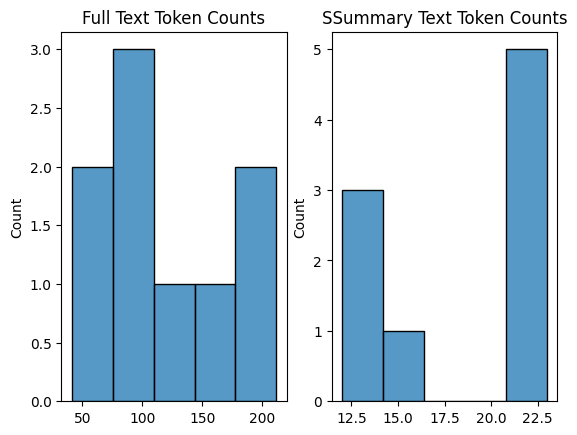

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("Full Text Token Counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("SSummary Text Token Counts")


"""Distribution of the Tokens """

In [31]:
N_EPOCHS = 3
BATCH_SIZE = 8 

data_module = SummaryDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

In [32]:
class SummaryModule(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = T5ForConditionalGeneration.from_pretrained(
            MODEL_NAME,
            return_dict=True
        )
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        output = self.model(
            input_ids, 
            attention_mask = attention_mask, 
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        )

        return output.loss, output.logits # loss in here 
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"] 

        
        loss, outputs = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask, # for the summary 
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss 
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"] 

        
        loss, outputs = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask, 
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)

        return loss 
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"] 

        
        loss, outputs = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask, # for the summary 
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)

        return loss 
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001) # if you learn more, you will forget the previous knowledge 
    

In [33]:
model = SummaryModule()

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

In [35]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)


logger = TensorBoardLogger("lightning_logs", name="patient_summary")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS,
    enable_progress_bar=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model, data_module)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SummarizeDataset' on <module '__main__' (built-in)>


In [ ]:
trained_model = SummaryModule.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze() # to speed up the inference 

In [ ]:
def summarize(text):
    text_encoding = tokenizer(
        text, 
        max_length = 512,
        padding="max_lenght",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    generated_ids = trained_model.model.generate(
        input_ids = text_encoding["input_ids"],
        attention_mask = text_encoding["attention_mask"],
        max_length = 150,
        num_beams = 2, # for beam search 
        repetition_penalty = 2.5, # to penalize the model,
        length_penalty = 1.0, 
        early_stopping = True
    )

    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_space=True)
        for gen_id in generated_ids
    ]

    return " ".join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row["Patient"]
model_summary = summarize(text)


In [ ]:
text

In [ ]:
sample_row["Description"]

In [ ]:
model_summary